1. 변수합칠때, 오류가 있다는 것을 발견했다.
2. initial_list_status1이 사라지지 않았다는 것을 발견해서 삭제했다.
3. feature_corr 분석을 통해 똑같은 값을 갖는 변수를 알게되었다. 
4. drop_columns = ['funded_amnt_inv', 'out_prncp_inv'] 컬럼을 삭제해줬다.
5. feature의 수가 너무 적어져서 걱정이다. 데이터를 너무 많이 만진 것 같다.(75개 -> 33개)
6. feature_corr 분석에서 0.97 상관관계를 갖는 feature가 존재했다. 더 확인할 필요가 있다.
7. fico_range_low, fico_range_low 는 1의 상관관계인데 다른데이터를 가지고 있다. 더 분석이 필요할 것 같다.
8. threshold < 0.4 를 통해 0.01 모델을 개선시켰다.
9. threshold를 더 낮춰보니 accuracy와 f1이 개선되었지만 실제로 점수 향상으로 이어지진 못했다. 
10. 데이터가 불균형하다보니(1은 많고 0은 적다) 1을 결과값으로 많이 가질수록 accuracy와 f1이 개선되는듯 보였다.
11. imbalanced data를 해결하기 위한 방법을 찾아봐야겠다.(over sampling, under sampling)
12. cost-sensitive learning 방법도 시도해보는게 좋을것 같다.(블로그 추천)
13. feature에 비해 트리들의 깊이가 깊다고 생각이 들었다.
14. 트리의 깊이를 줄여봤으나 좋은 성능을 얻지는 못했다.
15. 시도한 model parameter 
rnd_clf = RandomForestClassifier(max_depth = 10)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                               n_estimators = 50,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=6,
                                  num_leaves =60)
16. 현재까지 가장 좋은 성능을 보이는 parameter + threshold = 0.4
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=15,
                                  num_leaves =150)
17. 앞으로 시도해보면 좋을 일
- over sampling , under sampling, cost-sensitive learning
- features를 건들이지말고 학습시켜보자
- 상관관계있는 features 확인하기
- 트리의 깊이에 대한 고민

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [ ]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,0.253259,2491.282802,692.630550,696.630660,0.325690
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,18.051746,2706.262200,29.668017,29.668584,0.468634
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,

In [ ]:
# 결측치 확인 -> 결측치 0
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


# Train Valid Split

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [ ]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [ ]:
# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

0.31775

# 데이터 전처리

In [ ]:
# 컬럼 확인하기 -> 중복데이터 확인 -> 이름이 비슷한 columns 확인
X_train.columns  

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'emp_length1',
       'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5',
       'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1',
       'verification_status2', 'verification_status3', 'purpose1', 'purpose2',
       'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8',
       'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13',
       'purpose14', 'initial_list_status1', 'initial_list_status2',
       'mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_l

In [ ]:
 # 'emp_length1','emp_length2', 'emp_length3', 'emp_length4', 'emp_length5','emp_length6', 'emp_length7', 'emp_length8', 'emp_length9','emp_length10', 'emp_length11', 'emp_length12', 
 # 'home_ownership1', 'home_ownership2', 'home_ownership3', 'home_ownership4','home_ownership5', 'home_ownership6', 
 # 'verification_status1', 'verification_status2', 'verification_status3', 
 # 'purpose1', 'purpose2','purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13','purpose14',
 # 'initial_list_status1', 'initial_list_status2',
 # 'mths_since_last_delinq1', 'mths_since_last_delinq2','mths_since_last_delinq3', 'mths_since_last_delinq4', 'mths_since_last_delinq5', 'mths_since_last_delinq6','mths_since_last_delinq7', 'mths_since_last_delinq8',
 # 'mths_since_last_delinq9', 'mths_since_last_delinq10','mths_since_last_delinq11',
 
 # feature중 같은 속성을 가진 것들을 모아서 category값으로 변경

In [ ]:

X_train['emp_length2'] = X_train['emp_length2'].replace([1],2)
X_train['emp_length3'] = X_train['emp_length3'].replace([1],3)
X_train['emp_length4'] = X_train['emp_length4'].replace([1],4)
X_train['emp_length5'] = X_train['emp_length5'].replace([1],5)
X_train['emp_length6'] = X_train['emp_length6'].replace([1],6)
X_train['emp_length7'] = X_train['emp_length7'].replace([1],7)
X_train['emp_length8'] = X_train['emp_length8'].replace([1],8)
X_train['emp_length9'] = X_train['emp_length9'].replace([1],9)
X_train['emp_length10'] = X_train['emp_length10'].replace([1],10)
X_train['emp_length11'] = X_train['emp_length11'].replace([1],11)
X_train['emp_length12'] = X_train['emp_length12'].replace([1],12)

In [ ]:
#값이 잘 변경 됬는지 확인
X_train['emp_length9'].value_counts()

0    76339
9     3661
Name: emp_length9, dtype: int64

In [ ]:
drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

X_train['emp_length'] = X_train.loc[:,drop_columns].sum(axis=1)
X_train['emp_length'].value_counts() # 13개의 feature 1개의 feature로 변경

2     26015
3      7182
4      6432
11     6023
12     5342
1      5219
6      4869
5      4821
7      3719
9      3661
8      3612
10     3105
Name: emp_length, dtype: int64

In [ ]:
X_train = X_train.drop(columns= drop_columns, axis=1)

In [ ]:
# 대체된 columns 삭제됬는지 확인
X_train.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens',
       'home_ownership1', 'home_ownership2', 'home_ownership3',
       'home_ownership4', 'home_ownership5', 'home_ownership6',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14', 'initial_list_status1',
       'initial_list_status2', 'mths_since_last_delinq1',
       'mths_since_last_delinq2', 'mths_since_last_delinq3',
       'mths_since_last_delinq4', 'mths_since_last_delinq5',
       'mths_since_last_delinq6', 'mths_since_last_delinq7',
       'mths_since_last_delinq8', 'mths_since_last_delinq9',
       

In [ ]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

X_train['home_ownership2'] = X_train['home_ownership2'].replace([1],2)
X_train['home_ownership3'] = X_train['home_ownership3'].replace([1],3)
X_train['home_ownership4'] = X_train['home_ownership4'].replace([1],4)
X_train['home_ownership5'] = X_train['home_ownership5'].replace([1],5)
X_train['home_ownership6'] = X_train['home_ownership6'].replace([1],6)

X_train['home_ownership'] = X_train.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_train['home_ownership'].value_counts())

X_train = X_train.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_train.columns # 삭제가 잘됬는지 확인

2    37200
6    33914
5     8851
1       24
3        7
4        4
Name: home_ownership, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14', 'initial_list_status1',
       'initial_list_status2', 'mths_since_last_delinq1',
       'mths_since_last_delinq2', 'mths_since_last_delinq3',
       'mths_since_last_delinq4', 'mths_since_last_delinq5',
       'mths_since_last_delinq6', 'mths_since_last_delinq7',
       'mths_since_last_delinq8', 'mths_since_last_delinq9',
       'mths_since_last_delinq10', 'mths_since_last_delinq11', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 

In [ ]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

X_train['verification_status2'] = X_train['verification_status2'].replace([1],2)
X_train['verification_status3'] = X_train['verification_status3'].replace([1],3)


X_train['verification_status'] = X_train.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_train['verification_status'].value_counts())

X_train = X_train.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_train.columns # 삭제가 잘됬는지 확인

2    31234
1    25724
3    23042
Name: verification_status, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14', 'initial_list_status1',
       'initial_list_status2', 'mths_since_last_delinq1',
       'mths_since_last_delinq2', 'mths_since_last_delinq3',
       'mths_since_last_delinq4', 'mths_since_last_delinq5',
       'mths_since_last_delinq6', 'mths_since_last_delinq7',
       'mths_since_last_delinq8', 'mths_since_last_delinq9',
       'mths_since_last_delinq10', 'mths_since_last_delinq11', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
 

In [ ]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

X_train['purpose2'] = X_train['purpose2'].replace([1],2)
X_train['purpose3'] = X_train['purpose3'].replace([1],3)
X_train['purpose4'] = X_train['purpose4'].replace([1],4)
X_train['purpose5'] = X_train['purpose5'].replace([1],5)
X_train['purpose6'] = X_train['purpose6'].replace([1],6)
X_train['purpose7'] = X_train['purpose7'].replace([1],7)
X_train['purpose8'] = X_train['purpose8'].replace([1],8)
X_train['purpose9'] = X_train['purpose9'].replace([1],9)
X_train['purpose10'] = X_train['purpose10'].replace([1],10)
X_train['purpose11'] = X_train['purpose11'].replace([1],11)
X_train['purpose12'] = X_train['purpose12'].replace([1],12)
X_train['purpose13'] = X_train['purpose13'].replace([1],13)
X_train['purpose14'] = X_train['purpose14'].replace([1],14)


X_train['purpose'] = X_train.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_train['purpose'].value_counts())

X_train = X_train.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_train.columns # 삭제가 잘됬는지 확인

3     46683
2     18130
5      4827
10     4615
7      1583
12      890
8       869
1       780
9       584
13      558
6       344
14       80
11       57
Name: purpose, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens',
       'initial_list_status1', 'initial_list_status2',
       'mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11', 'funded_amnt', 'funded_amnt_inv',
       'total_rec_late_fee', 'term1', 'open_acc', 'installment', 'revol_util',
       'out_prncp', 'out_prncp_inv', 'total_rec_int', 'fico_range_low',
       'fico_range_high', 'emp_length', 'home_ownership',
       'verification_status', 'purpose'],
      dtype='object')

In [ ]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

X_train['initial_list_status2'] = X_train['initial_list_status2'].replace([1],2)

X_train['initial_list_status'] = X_train.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_train['initial_list_status'].value_counts())

X_train = X_train.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_train.columns # 삭제가 잘됬는지 확인

2    45237
1    34763
Name: initial_list_status, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens',
       'mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11', 'funded_amnt', 'funded_amnt_inv',
       'total_rec_late_fee', 'term1', 'open_acc', 'installment', 'revol_util',
       'out_prncp', 'out_prncp_inv', 'total_rec_int', 'fico_range_low',
       'fico_range_high', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'initial_list_status'],
      dtype='object')

In [ ]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

X_train['mths_since_last_delinq2'] = X_train['mths_since_last_delinq2'].replace([1],2)
X_train['mths_since_last_delinq3'] = X_train['mths_since_last_delinq3'].replace([1],3)
X_train['mths_since_last_delinq4'] = X_train['mths_since_last_delinq4'].replace([1],4)
X_train['mths_since_last_delinq5'] = X_train['mths_since_last_delinq5'].replace([1],5)
X_train['mths_since_last_delinq6'] = X_train['mths_since_last_delinq6'].replace([1],6)
X_train['mths_since_last_delinq7'] = X_train['mths_since_last_delinq7'].replace([1],7)
X_train['mths_since_last_delinq8'] = X_train['mths_since_last_delinq8'].replace([1],8)
X_train['mths_since_last_delinq9'] = X_train['mths_since_last_delinq9'].replace([1],9)
X_train['mths_since_last_delinq10'] = X_train['mths_since_last_delinq10'].replace([1],10)
X_train['mths_since_last_delinq11'] = X_train['mths_since_last_delinq11'].replace([1],11)


X_train['mths_since_last_delinq'] = X_train.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_train['mths_since_last_delinq'].value_counts())

X_train = X_train.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_train.columns # 삭제가 잘됬는지 확인

1     39024
3      4790
8      4258
2      4164
7      4156
5      4043
11     4021
10     4012
9      3946
6      3924
4      3662
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

# X_valid data 전처리 (=X_train data)



In [ ]:
X_valid.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'emp_length1',
       'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5',
       'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1',
       'verification_status2', 'verification_status3', 'purpose1', 'purpose2',
       'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8',
       'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13',
       'purpose14', 'initial_list_status1', 'initial_list_status2',
       'mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_l

In [ ]:
X_valid['emp_length2'] = X_valid['emp_length2'].replace([1],2)
X_valid['emp_length3'] = X_valid['emp_length3'].replace([1],3)
X_valid['emp_length4'] = X_valid['emp_length4'].replace([1],4)
X_valid['emp_length5'] = X_valid['emp_length5'].replace([1],5)
X_valid['emp_length6'] = X_valid['emp_length6'].replace([1],6)
X_valid['emp_length7'] = X_valid['emp_length7'].replace([1],7)
X_valid['emp_length8'] = X_valid['emp_length8'].replace([1],8)
X_valid['emp_length9'] = X_valid['emp_length9'].replace([1],9)
X_valid['emp_length10'] = X_valid['emp_length10'].replace([1],10)
X_valid['emp_length11'] = X_valid['emp_length11'].replace([1],11)
X_valid['emp_length12'] = X_valid['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

X_valid['emp_length'] = X_valid.loc[:,drop_columns].sum(axis=1)
print(X_valid['emp_length'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1)

2     6609
3     1759
4     1626
11    1532
1     1321
12    1299
6     1202
5     1127
7      945
8      920
9      908
10     752
Name: emp_length, dtype: int64


In [ ]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

X_valid['home_ownership2'] = X_valid['home_ownership2'].replace([1],2)
X_valid['home_ownership3'] = X_valid['home_ownership3'].replace([1],3)
X_valid['home_ownership4'] = X_valid['home_ownership4'].replace([1],4)
X_valid['home_ownership5'] = X_valid['home_ownership5'].replace([1],5)
X_valid['home_ownership6'] = X_valid['home_ownership6'].replace([1],6)

X_valid['home_ownership'] = X_valid.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_valid['home_ownership'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    9412
6    8341
5    2237
1       9
4       1
Name: home_ownership, dtype: int64


In [ ]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

X_valid['verification_status2'] = X_valid['verification_status2'].replace([1],2)
X_valid['verification_status3'] = X_valid['verification_status3'].replace([1],3)


X_valid['verification_status'] = X_valid.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_valid['verification_status'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    7786
1    6456
3    5758
Name: verification_status, dtype: int64


In [ ]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

X_valid['purpose2'] = X_valid['purpose2'].replace([1],2)
X_valid['purpose3'] = X_valid['purpose3'].replace([1],3)
X_valid['purpose4'] = X_valid['purpose4'].replace([1],4)
X_valid['purpose5'] = X_valid['purpose5'].replace([1],5)
X_valid['purpose6'] = X_valid['purpose6'].replace([1],6)
X_valid['purpose7'] = X_valid['purpose7'].replace([1],7)
X_valid['purpose8'] = X_valid['purpose8'].replace([1],8)
X_valid['purpose9'] = X_valid['purpose9'].replace([1],9)
X_valid['purpose10'] = X_valid['purpose10'].replace([1],10)
X_valid['purpose11'] = X_valid['purpose11'].replace([1],11)
X_valid['purpose12'] = X_valid['purpose12'].replace([1],12)
X_valid['purpose13'] = X_valid['purpose13'].replace([1],13)
X_valid['purpose14'] = X_valid['purpose14'].replace([1],14)


X_valid['purpose'] = X_valid.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_valid['purpose'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제


3     11598
2      4542
5      1213
10     1205
7       400
12      235
8       232
1       182
13      149
9       147
6        81
14        8
11        8
Name: purpose, dtype: int64


In [ ]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

X_valid['initial_list_status2'] = X_valid['initial_list_status2'].replace([1],2)

X_valid['initial_list_status'] = X_valid.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_valid['initial_list_status'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제


2    11320
1     8680
Name: initial_list_status, dtype: int64


In [ ]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

X_valid['mths_since_last_delinq2'] = X_valid['mths_since_last_delinq2'].replace([1],2)
X_valid['mths_since_last_delinq3'] = X_valid['mths_since_last_delinq3'].replace([1],3)
X_valid['mths_since_last_delinq4'] = X_valid['mths_since_last_delinq4'].replace([1],4)
X_valid['mths_since_last_delinq5'] = X_valid['mths_since_last_delinq5'].replace([1],5)
X_valid['mths_since_last_delinq6'] = X_valid['mths_since_last_delinq6'].replace([1],6)
X_valid['mths_since_last_delinq7'] = X_valid['mths_since_last_delinq7'].replace([1],7)
X_valid['mths_since_last_delinq8'] = X_valid['mths_since_last_delinq8'].replace([1],8)
X_valid['mths_since_last_delinq9'] = X_valid['mths_since_last_delinq9'].replace([1],9)
X_valid['mths_since_last_delinq10'] = X_valid['mths_since_last_delinq10'].replace([1],10)
X_valid['mths_since_last_delinq11'] = X_valid['mths_since_last_delinq11'].replace([1],11)


X_valid['mths_since_last_delinq'] = X_valid.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(X_valid['mths_since_last_delinq'].value_counts())

X_valid = X_valid.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
X_valid.columns # 삭제가 잘됬는지 확인

1     9908
3     1219
8     1085
2     1072
5     1032
10     991
7      978
9      950
6      932
11     925
4      908
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'emp_length',
       'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

# EDA 추가분석



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train.corr()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
int_rate,1.000000,-0.090365,0.176003,0.037120,0.247205,0.036045,-0.053186,-0.063186,0.005761,0.016010,0.001000,-0.112260,0.012821,0.004667,0.007553,0.084697,0.084723,0.069486,-0.372643,-0.033830,0.105557,0.243612,-0.000370,-0.000371,0.404579,-0.393438,-0.393435,0.017533,0.088018,0.259981,0.159695,-0.219477,0.021306
annual_inc,-0.090365,1.000000,-0.162268,0.034646,0.030858,-0.004313,0.259544,0.159521,-0.002893,0.011471,-0.001492,0.349211,0.007350,0.006559,0.033671,0.285240,0.285252,0.041541,-0.020917,0.119865,0.279693,0.039571,0.003334,0.003335,0.134970,0.066570,0.066571,-0.073128,-0.130902,0.021856,0.007272,0.030816,0.021489
dti,0.176003,-0.162268,1.000000,-0.012258,0.000898,-0.051045,0.134761,0.222348,-0.007787,0.004588,-0.013295,-0.005998,-0.004330,-0.007654,-0.035972,-0.000520,-0.000561,-0.001231,-0.043943,0.285266,0.008239,0.170257,0.002947,0.002948,0.064588,-0.065307,-0.065311,0.021492,0.009294,0.075963,-0.062387,-0.014734,-0.022301
delinq_2yrs,0.037120,0.034646,-0.012258,1.000000,0.025360,-0.019250,-0.034211,0.123775,0.076219,0.136433,0.003712,0.073058,0.140176,0.029258,0.007592,-0.002719,-0.002743,0.041436,0.014120,0.054699,0.005817,-0.021278,0.003501,0.003503,0.016386,-0.167184,-0.167182,-0.033907,-0.057819,-0.005885,0.021923,0.003548,-0.054397
inq_last_6mths,0.247205,0.030858,0.000898,0.025360,1.000000,0.061672,-0.012152,0.152242,0.007231,-0.003221,0.007254,0.031598,0.009284,-0.004660,0.005417,-0.002679,-0.002663,0.014660,-0.043772,0.134676,0.015673,-0.086796,-0.004483,-0.004490,0.052836,-0.095089,-0.095089,-0.005388,-0.036157,0.074977,0.029597,-0.064286,0.038061
pub_rec,0.036045,-0.004313,-0.051045,-0.019250,0.061672,1.000000,-0.095357,-0.000083,0.013382,0.000196,0.025478,-0.069261,-0.002370,0.007310,0.741389,-0.068307,-0.068308,0.008294,0.039876,-0.029161,-0.054508,-0.077488,-0.001802,-0.001808,-0.038590,-0.178907,-0.178904,0.017042,0.008629,0.034667,0.025739,0.006049,0.058489
revol_bal,-0.053186,0.259544,0.134761,-0.034211,-0.012152,-0.095357,1.000000,0.198651,-0.031232,0.000466,-0.032773,0.431557,-0.016181,0.001437,-0.012504,0.345655,0.345622,0.027824,-0.069374,0.230219,0.330873,0.230126,0.000322,0.000324,0.202104,0.059274,0.059269,-0.059341,-0.163514,0.055347,-0.065075,0.017857,-0.062714
total_acc,-0.063186,0.159521,0.222348,0.123775,0.152242,-0.000083,0.198651,1.000000,0.006549,0.029554,0.024607,0.317833,0.041787,0.002063,-0.024781,0.217577,0.217577,0.006157,-0.085664,0.700631,0.199079,-0.106604,-0.002309,-0.002306,0.111188,0.029517,0.029518,-0.054041,-0.213123,0.029063,-0.051809,0.007206,0.125316
collections_12_mths_ex_med,0.005761,-0.002893,-0.007787,0.076219,0.007231,0.013382,-0.031232,0.006549,1.000000,0.015643,0.060038,-0.007553,0.035258,0.007003,0.011423,-0.024084,-0.024090,0.002036,0.017640,0.008488,-0.019821,-0.041991,-0.001718,-0.001717,-0.013626,-0.066539,-0.066538,-0.003100,0.003045,0.007367,0.007958,0.009226,0.021986
acc_now_delinq,0.016010,0.011471,0.004588,0.136433,-0.003221,0.000196,0.000466,0.029554,0.015643,1.000000,0.010201,0.028627,0.080086,0.141392,0.008456,0.002309,0.002297,0.005154,0.002582,0.022543,0.005362,-0.038146,-0.000967,-0.000967,0.007232,-0.030362,-0.030361,-0.002728,-0.018084,0.008623,0.003853,0.002105,-0.036623


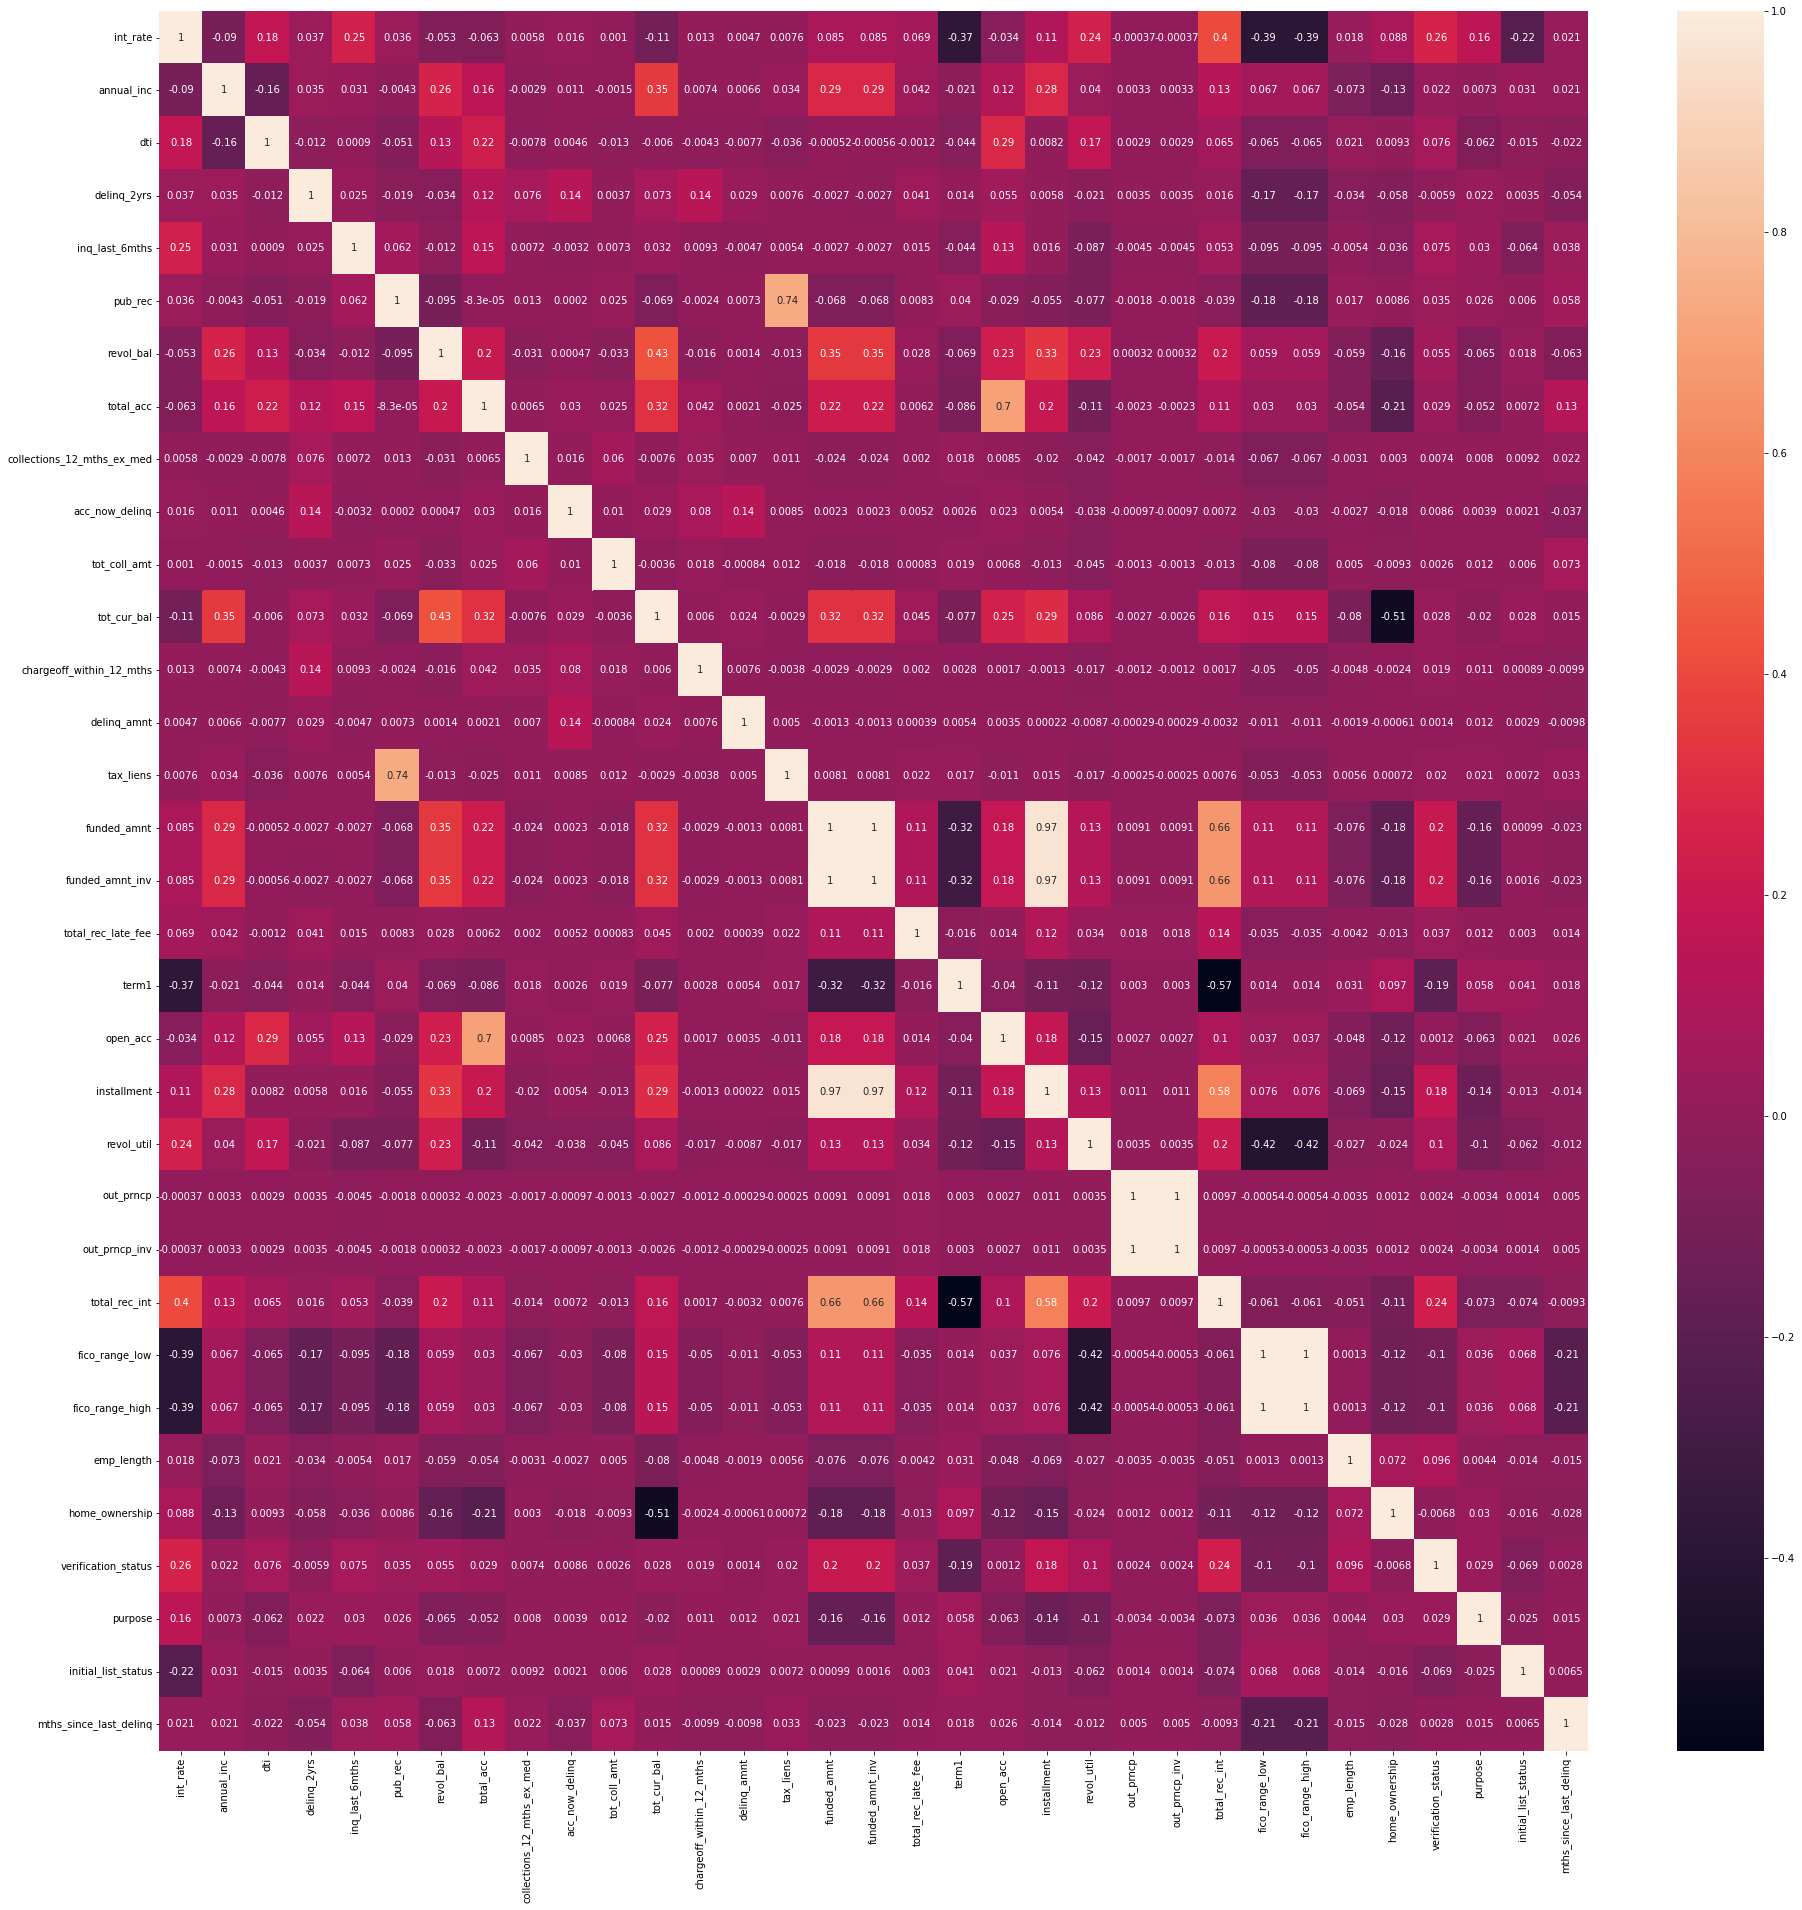

In [ ]:
corr_df = X_train.corr()

plt.figure(figsize=(32,32))
sns.heatmap(corr_df, annot = True)
plt.show()

In [ ]:
drop_columns = ['funded_amnt_inv', 'out_prncp_inv']
X_train = X_train.drop(columns = drop_columns, axis=1)
X_valid = X_valid.drop(columns = drop_columns, axis=1)

# Model Training


In [ ]:
# threshold 변경 및 성능 확인 할 수 있는 방법 : 모델.predict_proba -> (0이나올확률, 1이나올확률) 
# for i in [0.4, 0.45, 0.55, 0.6] :
#   print(f'threshold : {i}')
#   get_clf_eval(y_valid, y_pred_prob[:,1]> i)

# Ensemble(Voting)

In [ ]:

# # rnd_clf  = RandomForestClassifier()
# # lgbm_clf = LGBMClassifier()
# # rid_clf = RidgeClassifier()
# # dtc_clf = DecisionTreeClassifier()
# # svm_clf = SVC()
# # ada_clf = AdaBoostClassifier()
# # gbc_clf = GradientBoostingClassifier()
# # bag_clf = BaggingClassifier()
# # ext_clf = ExtraTreesClassifier()
# # knn_clf = KNeighborsClassifier()
# # svc_clf = SVC()

# rnd_clf = RandomForestClassifier(max_depth = 20)
# xgb_clf = xgboost.XGBClassifier(max_depth = 6,
#                                 n_estimators = 100,
#                                 eval_metric='mlogloss')
# lgbm_clf = LGBMClassifier(max_depth=15,
#                                   num_leaves =150)


# voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting='soft')

In [ ]:
# for clf in (rnd_clf, lgbm_clf, xgb_clf) :
#     clf.fit(X_train, y_train)
#     y_pred_vote = clf.predict(X_valid)

# # ensemble(voting) 성능 확인
# get_clf_eval(y_valid, y_pred_vote)

# Ensemble(Stacking)


정확도: 0.7541
정밀도: 0.6440
재현율: 0.5061
AUC: 0.6879
F1: 0.5667


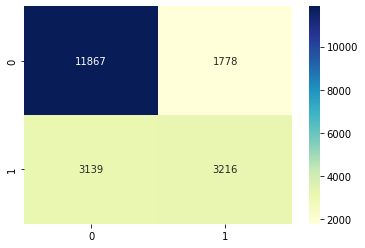

In [ ]:
# rnd_clf = RandomForestClassifier(max_depth = 10)
# xgb_clf = xgboost.XGBClassifier(max_depth = 6,
#                                 n_estimators = 50,
#                                 eval_metric='mlogloss')
# lgbm_clf = LGBMClassifier(max_depth=6,
#                                   num_leaves =60)


# stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf),('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
# stacking_clf.fit(X_train, y_train)

# y_pred_stack = stacking_clf.predict(X_valid)
# y_pred_prob = stacking_clf.predict_proba(X_valid)

# # ensemble(stacking) 성능 확인
# get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7567
정밀도: 0.6535
재현율: 0.4983
AUC: 0.6876
F1: 0.5655


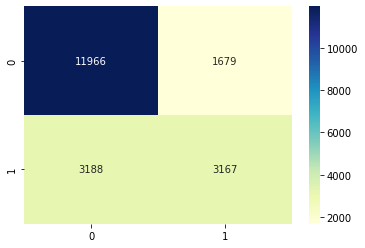

In [ ]:
rnd_clf = RandomForestClassifier(max_depth = 20)
xgb_clf = xgboost.XGBClassifier(max_depth = 6,
                                n_estimators = 100,
                                eval_metric='mlogloss')
lgbm_clf = LGBMClassifier(max_depth=15,
                                  num_leaves =150)


stacking_clf = StackingClassifier(estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

y_pred_stack = stacking_clf.predict(X_valid)
y_pred_prob = stacking_clf.predict_proba(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
# y_pred_prob = stacking_clf.predict_proba(X_valid)
y_pred_prob[:,1] > 0.4 

# 출력값은 true, false 형태이다.

array([ True,  True,  True, ..., False, False, False])

threshold : 0.3

정확도: 0.7063
정밀도: 0.5253
재현율: 0.7841
AUC: 0.7270
F1: 0.6291
threshold : 0.35

정확도: 0.7251
정밀도: 0.5507
재현율: 0.7327
AUC: 0.7272
F1: 0.6288
threshold : 0.38

정확도: 0.7371
정밀도: 0.5722
재현율: 0.6842
AUC: 0.7230
F1: 0.6232
threshold : 0.4

정확도: 0.7440
정밀도: 0.5873
재현율: 0.6529
AUC: 0.7196
F1: 0.6184
threshold : 0.42

정확도: 0.7503
정밀도: 0.6068
재현율: 0.6088
AUC: 0.7125
F1: 0.6078
threshold : 0.45

정확도: 0.7518
정밀도: 0.6168
재현율: 0.5777
AUC: 0.7052
F1: 0.5966


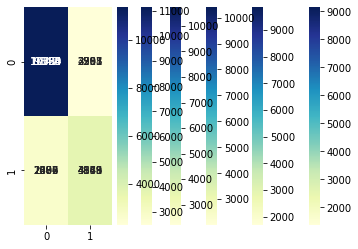

In [ ]:
for i in [0.3, 0.35, 0.38, 0.4, 0.42, 0.45] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,1]>i) # 0.5, 0.6, # 0.3 # 0.2 # 0.1

# threshold > 0.4  -> 1예측값에 시도

# 정확도: 0.7440
# 정밀도: 0.5873
# 재현율: 0.6529
# AUC: 0.7196
# F1: 0.6184

# threshold < 0.7  -> 0 예측값의 시도
# 정확도: 0.7427
# 정밀도: 0.5858
# 재현율: 0.6809
# AUC: 0.7264
# F1: 0.6298

# 데이터 불균형때문에 더 중요한 점수가 있을 것 같다.

threshold : 0.4

정확도: 0.7492
정밀도: 0.7138
재현율: 0.3667
AUC: 0.6485
F1: 0.4845
threshold : 0.5

정확도: 0.7561
정밀도: 0.6529
재현율: 0.5152
AUC: 0.6927
F1: 0.5759
threshold : 0.6

정확도: 0.7427
정밀도: 0.5858
재현율: 0.6809
AUC: 0.7264
F1: 0.6298
threshold : 0.7

정확도: 0.7109
정밀도: 0.5341
재현율: 0.7876
AUC: 0.7311
F1: 0.6365


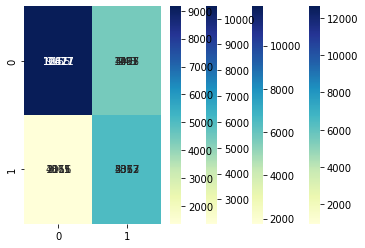

In [ ]:
for i in [0.4, 0.5, 0.6, 0.7 ] :
  print(f'threshold : {i}')
  get_clf_eval(y_valid, y_pred_prob[:,0]<i) # 0.5, 0.6, # 0.3 # 0.2 # 0.1

In [ ]:

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20220126_DAY27(1주차 모의경진대회)/test.csv')

In [ ]:
df_test['emp_length2'] = df_test['emp_length2'].replace([1],2)
df_test['emp_length3'] = df_test['emp_length3'].replace([1],3)
df_test['emp_length4'] = df_test['emp_length4'].replace([1],4)
df_test['emp_length5'] = df_test['emp_length5'].replace([1],5)
df_test['emp_length6'] = df_test['emp_length6'].replace([1],6)
df_test['emp_length7'] = df_test['emp_length7'].replace([1],7)
df_test['emp_length8'] = df_test['emp_length8'].replace([1],8)
df_test['emp_length9'] = df_test['emp_length9'].replace([1],9)
df_test['emp_length10'] = df_test['emp_length10'].replace([1],10)
df_test['emp_length11'] = df_test['emp_length11'].replace([1],11)
df_test['emp_length12'] = df_test['emp_length12'].replace([1],12)

drop_columns = ['emp_length1','emp_length2','emp_length3','emp_length4','emp_length5','emp_length6','emp_length7','emp_length8','emp_length9', 'emp_length10', 'emp_length11', 'emp_length12']

df_test['emp_length'] = df_test.loc[:,drop_columns].sum(axis=1)
print(df_test['emp_length'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1)

2     11574
3      3286
4      2849
11     2702
12     2357
1      2301
6      2156
5      2128
9      1709
7      1687
8      1641
10     1426
Name: emp_length, dtype: int64


In [ ]:
drop_columns = ['home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6']

df_test['home_ownership2'] = df_test['home_ownership2'].replace([1],2)
df_test['home_ownership3'] = df_test['home_ownership3'].replace([1],3)
df_test['home_ownership4'] = df_test['home_ownership4'].replace([1],4)
df_test['home_ownership5'] = df_test['home_ownership5'].replace([1],5)
df_test['home_ownership6'] = df_test['home_ownership6'].replace([1],6)

df_test['home_ownership'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['home_ownership'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    16792
6    15054
5     3957
1        9
4        2
3        2
Name: home_ownership, dtype: int64


In [ ]:
drop_columns = ['verification_status1', 'verification_status2', 'verification_status3']

df_test['verification_status2'] = df_test['verification_status2'].replace([1],2)
df_test['verification_status3'] = df_test['verification_status3'].replace([1],3)


df_test['verification_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['verification_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    14020
1    11473
3    10323
Name: verification_status, dtype: int64


In [ ]:
drop_columns = ['purpose1',
       'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14']

df_test['purpose2'] = df_test['purpose2'].replace([1],2)
df_test['purpose3'] = df_test['purpose3'].replace([1],3)
df_test['purpose4'] = df_test['purpose4'].replace([1],4)
df_test['purpose5'] = df_test['purpose5'].replace([1],5)
df_test['purpose6'] = df_test['purpose6'].replace([1],6)
df_test['purpose7'] = df_test['purpose7'].replace([1],7)
df_test['purpose8'] = df_test['purpose8'].replace([1],8)
df_test['purpose9'] = df_test['purpose9'].replace([1],9)
df_test['purpose10'] = df_test['purpose10'].replace([1],10)
df_test['purpose11'] = df_test['purpose11'].replace([1],11)
df_test['purpose12'] = df_test['purpose12'].replace([1],12)
df_test['purpose13'] = df_test['purpose13'].replace([1],13)
df_test['purpose14'] = df_test['purpose14'].replace([1],14)


df_test['purpose'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['purpose'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

3     20956
2      7897
5      2189
10     2104
7       748
8       421
1       371
12      370
9       307
13      246
6       153
14       32
11       22
Name: purpose, dtype: int64


In [ ]:
drop_columns = ['initial_list_status1', 'initial_list_status2']

df_test['initial_list_status2'] = df_test['initial_list_status2'].replace([1],2)

df_test['initial_list_status'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['initial_list_status'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제

2    20245
1    15571
Name: initial_list_status, dtype: int64


In [ ]:
drop_columns = ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11']

df_test['mths_since_last_delinq2'] = df_test['mths_since_last_delinq2'].replace([1],2)
df_test['mths_since_last_delinq3'] = df_test['mths_since_last_delinq3'].replace([1],3)
df_test['mths_since_last_delinq4'] = df_test['mths_since_last_delinq4'].replace([1],4)
df_test['mths_since_last_delinq5'] = df_test['mths_since_last_delinq5'].replace([1],5)
df_test['mths_since_last_delinq6'] = df_test['mths_since_last_delinq6'].replace([1],6)
df_test['mths_since_last_delinq7'] = df_test['mths_since_last_delinq7'].replace([1],7)
df_test['mths_since_last_delinq8'] = df_test['mths_since_last_delinq8'].replace([1],8)
df_test['mths_since_last_delinq9'] = df_test['mths_since_last_delinq9'].replace([1],9)
df_test['mths_since_last_delinq10'] = df_test['mths_since_last_delinq10'].replace([1],10)
df_test['mths_since_last_delinq11'] = df_test['mths_since_last_delinq11'].replace([1],11)


df_test['mths_since_last_delinq'] = df_test.loc[:,drop_columns].sum(axis=1) # 컬럼 합치기
print(df_test['mths_since_last_delinq'].value_counts())

df_test = df_test.drop(columns= drop_columns, axis=1) # 대체된 컬럼 삭제
df_test.columns # 삭제가 잘됬는지 확인

1     17595
3      2090
2      1949
11     1861
7      1861
5      1825
8      1768
6      1731
9      1721
4      1711
10     1704
Name: mths_since_last_delinq, dtype: int64


Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'funded_amnt_inv', 'total_rec_late_fee', 'term1', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'ID',
       'emp_length', 'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

In [ ]:
drop_columns = ['funded_amnt_inv', 'out_prncp_inv']
df_test = df_test.drop(columns = drop_columns, axis=1)

In [ ]:
df_test.columns 

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'funded_amnt',
       'total_rec_late_fee', 'term1', 'open_acc', 'installment', 'revol_util',
       'out_prncp', 'total_rec_int', 'fico_range_low', 'fico_range_high', 'ID',
       'emp_length', 'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'mths_since_last_delinq'],
      dtype='object')

# Submission

In [ ]:
# 제출 양식 다운로드

y_pred_prob = stacking_clf.predict_proba(df_test.drop(columns=['ID']))
submit['answer'] = y_pred_prob[:,1] > 0.4
submit['answer'] = submit['answer'].astype('int')
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/20220128_DAY29/prediction5.csv', index=False)